### 1. TESTING THE DEEPLAB MODEL FOR PERSON SEGMENTATION

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

In [2]:
def load_model():
    # Load the DeepLab v3 model to system
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f'Using device: {device}')
    model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
    model.to(device).eval()
    return model

In [3]:
def get_pred(img, model):
    # See if GPU is available and if yes, use it
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Define the standard transforms that need to be done at inference time
    imagenet_stats = [[0.485, 0.456, 0.406], [0.485, 0.456, 0.406]]
    preprocess = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean = imagenet_stats[0],std  = imagenet_stats[1])
    ])
    # All pre-trained models expect input images in mini-batches of 3-channel RGB images
    # of shape (N, 3, H, W). Our image is (3, H, W) so we have to unsqueeze to get (1, 3, H, W)
    input_tensor = preprocess(img).unsqueeze(0)
    input_tensor = input_tensor.to(device)

    # Make the predictions for labels across the image
    with torch.no_grad():
        output = model(input_tensor)["out"][0]
        output = output.argmax(0)

    # Return the predictions
    return output.cpu().numpy()

Using device: cpu


Using cache found in /home/dwayne99/.cache/torch/hub/pytorch_vision_v0.6.0


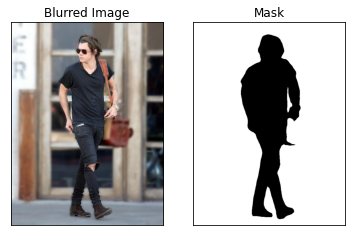

In [11]:
# Define the kernel size for applying Gaussian Blur
blur_value = (21, 21)

frame = cv2.imread('tests/harry1.jpeg')
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

# Read the frame's width, height, channels and get the labels' predictions from utilities
width, height, channels = frame.shape
model = load_model()
labels = get_pred(frame, model)

# Wherever there's empty space/no person, the label is zero 
# Hence identify such areas and create a mask (replicate it across RGB channels)
mask = labels == 0
mask = np.repeat(mask[:, :, np.newaxis], channels, axis = 2)

# Apply the Gaussian blur for background with the kernel size specified in constants above
blur = cv2.GaussianBlur(frame, blur_value, 0)
frame[mask] = blur[mask]

# sublot for blurred background image
plt.subplot(1, 2, 1)
plt.imshow(frame)
plt.xticks([]);plt.yticks([])
plt.title('Blurred Image')

# sublot for mask
plt.subplot(1, 2, 2)
plt.imshow(mask*255)
plt.xticks([]);plt.yticks([])
plt.title('Mask')
cv2.imwrite('temp/harry1.jpeg',cv2.cvtColor(frame,cv2.COLOR_RGB2BGR))
plt.show()

### 2. Doing the same using helper functions from utils

In [3]:
import cv2
from utils import *
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,15)

Enter path of the image:  tests/harry1.jpeg


Using device: cpu


Using cache found in /home/dwayne99/.cache/torch/hub/pytorch_vision_v0.6.0


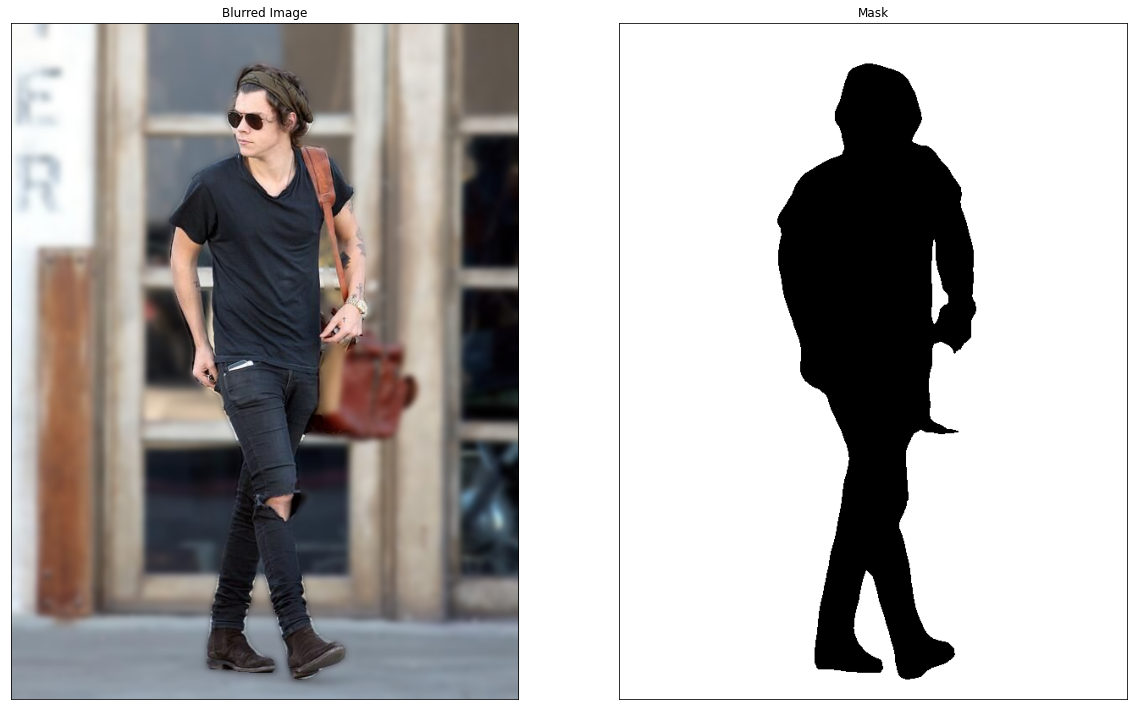

In [4]:
IMG_PATH = input('Enter path of the image: ')
img = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

model = load_model()
seg = get_pred(img,model)
blur,mask = blur_background(img,seg)

plot_blur_mask(blur,mask)